In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
from google.colab import drive
#drive.mount('/content/drive/My Drive/Auto_Contouring')
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
x = np.load("/content/drive/My Drive/Auto_Contouring/X.npy")
y = np.load("/content/drive/My Drive/Auto_Contouring/Y.npy")
x1 = np.load("/content/drive/My Drive/Auto_Contouring/X1.npy")
y1 = np.load("/content/drive/My Drive/Auto_Contouring/Y1.npy")

In [ ]:
def every_other(x,y):
  out_x = np.zeros((0,63,64,64,3))
  out_y = np.zeros((0,63,64,64,1))
  for i in range(0,len(x),2):
    half_x1 = x[i:(i+1),...]
    half_y1 = y[i:(i+1),...]
    half_x2 = x[(i+1):(i+2),1:,...]
    half_y2 = y[(i+1):(i+2),1:,...]
    full_x = np.concatenate((np.flip(half_x1,axis = 1), half_x2),axis = 1)
    full_y = np.concatenate((np.flip(half_y1,axis = 1), half_y2),axis = 1)
    print(full_x.shape)
    out_x = np.concatenate((out_x, full_x),axis = 0)
    out_y = np.concatenate((out_y, full_y),axis = 0)
  return out_x,out_y

x1,y1 = every_other(x1,y1)
x,y = every_other(x,y)


(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 64, 3)
(1, 63, 64, 

In [ ]:
from torch.nn import init
class LayerNormalization(nn.Module):
    "Layer Normalization layer for `n_channels`."
    def __init__(self, n_channels, dim):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(1,n_channels,1,1))
        self.beta = nn.Parameter(torch.zeros(1,n_channels,1,1))
        self.dim = dim
        self.eps = 1e-6
    def forward(self, x):
        #Notation from the paper.
      mean = torch.mean(x, dim=self.dim, keepdim=True)
      var = ((x - mean)*(x-mean)).mean(dim=self.dim, keepdim=True)
      new_mean =  (x - mean) / torch.sqrt(var + self.eps)
      new_mean = new_mean*self.gamma + self.beta
      return new_mean


def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        super().__init__()

        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding2D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 4) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 4d tensor of size (batch_size, x, y, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, ch)
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor has to be 4d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1)
        emb_y = get_emb(sin_inp_y)
        emb = torch.zeros((x, y, self.channels * 2), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, : self.channels] = emb_x
        emb[:, :, self.channels : 2 * self.channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(tensor.shape[0], 1, 1, 1)
        return self.cached_penc

class PositionalEncodingPermute2D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x, y) instead of (batchsize, x, y, ch)
        """
        super(PositionalEncodingPermute2D, self).__init__()
        self.penc = PositionalEncoding2D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 3, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 3, 1, 2)

    @property
    def org_channels(self):
        return self.penc.org_channels


def extract_patches(x,kc,kh,kw):
  batch_size = x.data.size()[0]
  patches = x.unfold(1, kc, kc).unfold(2, kh, kh).unfold(3, kw, kw)
  unfold_shape = patches.size()
  patches = patches.contiguous().view(batch_size,-1, kc, kh, kw)
  return patches,unfold_shape

def reshape_back(patches,unfold_shape):
  batch_size = patches.data.size()[0]
  patches_orig = patches.view(unfold_shape)
  output_c = unfold_shape[1] * unfold_shape[4]
  output_h = unfold_shape[2] * unfold_shape[5]
  output_w = unfold_shape[3] * unfold_shape[6]

  patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
  patches_orig = patches_orig.view(batch_size, output_c, output_h, output_w)
  return patches_orig

In [ ]:

def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc


class PositionalEncodingPermute1D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x) instead of (batchsize, x, ch)
        """
        super(PositionalEncodingPermute1D, self).__init__()
        self.penc = PositionalEncoding1D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 2, 1)

    @property
    def org_channels(self):
        return self.penc.org_channels


In [ ]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def get_mask(window_size, shift_size,H,W):
  img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
  h_slices = (slice(0, -window_size),
              slice(-window_size, -shift_size),
              slice(-shift_size, None))
  w_slices = (slice(0, -window_size),
              slice(-window_size, -shift_size),
              slice(-shift_size, None))
  cnt = 0
  for h in h_slices:
      for w in w_slices:
          img_mask[:, h, w, :] = cnt
          cnt += 1

  mask_windows = window_partition(img_mask, window_size)  # nW, window_size, window_size, 1
  mask_windows = mask_windows.view(-1, window_size * window_size)

  attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
  attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
  return attn_mask

def generate_distance_mask(shape = (256,256),pixels = 2):
    mask = np.ones(shape)
    for i in range(0,shape[0]): 
        col = np.int32(np.sqrt(shape[1]))
        m = mask[i,...]
        m = m.reshape(col, col)
        t = np.floor(i/col)
        pos = i%col
        s = np.int32(t - pixels + 1)
        e = np.int32(t + pixels + 1)
        if s < 0:
            s = 0
        if e > col:
            e = col
        for j in range(s,e):
            if pos - pixels > 0:
                m[j,0:(pos-pixels)] = 0#float('-inf')
            m[j,(pos+pixels + 1):col] = 0#float('-inf')
        m[0:s,:] = 0#float('-inf')
        m[e:col,:] = 0#float('-inf')
        m = m.reshape(shape[0])
        mask[i,...] = m
    return mask

In [ ]:
class ConvGRUCell(nn.Module):
    """
    Generate a convolutional GRU cell
    """

    def __init__(self, input_size, filter_size,height,width):
        super().__init__()

        self.filter_size = filter_size
        if filter_size == 256:
          self.p1,self.p2 = 2,2
          self.mask_size = 2
        if filter_size == 128:
          self.p1,self.p2 = 2,2
          self.mask_size = 5

        if filter_size == 64:
          self.p1,self.p2 = 2,2
          self.mask_size = 6

        if filter_size == 32:
          self.p1,self.p2 = 2,2
          self.mask_size = 10


        self.input_size = input_size
        self.q_k_dim = 128
        def init_weights(m):
            if isinstance(m, nn.Conv2d):
                torch.nn.init.zeros_(m.bias)
                torch.nn.init.kaiming_normal_(m.weight)

        self.update = nn.Sequential(
            nn.Conv2d(input_size*2,filter_size, kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(inplace=True)
        )
        self.update.apply(init_weights)

        self.num_patches = height*width//(self.p1*self.p2)
        print(self.num_patches)
        self.in_patches_size = self.p1*self.p2*self.filter_size




        def init_linear(m):
          if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)



        self.num_heads = 4

        self.query_linear = nn.Linear(self.in_patches_size, self.q_k_dim*self.num_heads)
        #self.query_linear.apply(init_linear)
        self.key_linear = nn.Linear(self.in_patches_size, self.q_k_dim*self.num_heads)
        #self.key_linear.apply(init_linear)
        self.value_linear = nn.Linear(self.in_patches_size, self.q_k_dim*self.num_heads)
        #self.value_linear.apply(init_linear)


        # self.query_linear = query_linear
        # self.key_linear = key_linear
        #self.value_linear = value_linear


        self.out_linear = nn.Sequential(
            nn.Linear(self.q_k_dim*self.num_heads, self.in_patches_size),
            #nn.ReLU(inplace = True)
          # nn.Tanh()
        )
        #self.out_linear.apply(init_linear)

        self.l_norm = LayerNormalization(self.filter_size, 2)
        #self.pos = PositionalEncoding(self.in_patches_size,0, max_len = self.num_patches)
        self.pos = PositionalEncodingPermute2D(self.filter_size)
        self.softmax = nn.Softmax(dim = 2)


 
    def recur_step(self, previous,current,t):
        batch_size = previous.data.size()[0]
        pos_= self.pos(previous)

        if t == 0:
          previous = torch.add(previous,pos_)
        current = torch.add(current,pos_)


        previous,u_s = extract_patches(previous, self.filter_size, self.p1, self.p2)
        current,u_s = extract_patches(current, self.filter_size, self.p1, self.p2)


        shape = current.shape

        x_in_p = previous.view(shape[0],shape[1],shape[2]*shape[3]*shape[4])

        query = current.view(shape[0]*shape[1],shape[2]*shape[3]*shape[4])
        key = previous.view(shape[0]*shape[1],shape[2]*shape[3]*shape[4])
        value = previous.view(shape[0]*shape[1],shape[2]*shape[3]*shape[4])





        query = self.query_linear(query)
        key = self.query_linear(key)
        value = key#self.value_linear(value)


        query = query.view(shape[0], shape[1], self.num_heads, self.q_k_dim)
        query = query.permute(0,2,1,3)
        query = query.reshape(shape[0]*self.num_heads, shape[1],self.q_k_dim)


        key = key.view(shape[0], shape[1], self.num_heads, self.q_k_dim)
        key = key.permute(0,2,1,3)
        key = key.reshape(shape[0]*self.num_heads, shape[1],self.q_k_dim)

        value = value.view(shape[0], shape[1], self.num_heads, self.q_k_dim)
        value = value.permute(0,2,1,3)
        value = value.reshape(shape[0]*self.num_heads, shape[1],self.q_k_dim)






        attention_weights = torch.bmm(query,key.permute(0,2,1))
        # attention_weights = attention_weights/np.sqrt(self.q_k_dim)
        attention_weights = self.softmax(attention_weights)
        # if t == 4:
        #   plt.imshow(attention_weights[0,...].cpu().detach())
        #   plt.pause(.2)


        value = torch.bmm(attention_weights,value)


        value = value.view(shape[0], self.num_heads, shape[1], self.q_k_dim )
        value = value.permute(0,2,1,3)
        value = value.reshape(shape[0], shape[1], self.num_heads*self.q_k_dim)


        value = self.out_linear(value.view(shape[0]*shape[1],self.q_k_dim*self.num_heads))
        value = value.view(shape[0],shape[1], shape[2]*shape[3]*shape[4])

        value = value + x_in_p
        value = value.view(shape[0],shape[1], shape[2],shape[3],shape[4])
        value = self.l_norm(value)
        value = F.relu(value)
        value = reshape_back(value, u_s)

        return value

    def forward(self, input, prev_state,t, transform = True):

        # get batch and spatial sizes
        batch_size = input.data.size()[0]
        spatial_size = input.data.size()[2:]

        # generate empty prev_state, if None is provided
        if prev_state is None:
            state_size = [batch_size, self.filter_size] + list(spatial_size)
            if torch.cuda.is_available():
                prev_state = Tensor(torch.zeros(state_size)).cuda()
            else:
                prev_state = Tensor(torch.zeros(state_size))
        if transform:
          prev_state = self.recur_step(prev_state, input,t)
        stacked_inputs = torch.cat([prev_state, input], dim=1)
        new_state = self.update(stacked_inputs)

        return new_state



class AttentionConvRNN(nn.Module):

    def __init__(self, input_size, hidden_size, kernel_size, n_layers, h_w,query_linear, key_linear,value_linear,q_k_dim):
        '''
        Generates a multi-layer convolutional GRU.
        Preserves spatial dimensions across cells, only altering depth.
        Parameters
        ----------
        input_size : integer. depth dimension of input tensors.
        hidden_sizes : integer or list. depth dimensions of hidden state.
            if integer, the same hidden size is used for all cells.
        kernel_sizes : integer or list. sizes of Conv2d gate kernels.
            if integer, the same kernel size is used for all cells.
        n_layers : integer. number of chained `ConvGRUCell`.
        '''
    
        super(AttentionConvRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.h_w = h_w
        self.cell = ConvGRUCell(self.input_size, self.hidden_size,self.h_w, self.h_w)
    def forward(self, x, hidden=None):
        '''
        Parameters
        ----------
        x : 4D input tensor. (batch, channels,time_step, height, width).
        hidden : list of 4D hidden state representations. (batch, channels, height, width).
        Returns
        -------
        upd_hidden : 5D hidden representation. (batch, channels, time_step,height, width).
        '''
        #cell_hidden = None
        
        input_ = x
        cell_hidden = input_[:,:,0,:,:]
        upd_hidden = []
        for time_step in range(0,x.shape[2]):
            x_in = input_[:,:,time_step,:,:]      
            #cell_hidden = hidden[time_step]
            # pass through layer
            cell_hidden = self.cell(x_in, cell_hidden, time_step)
            upd_hidden.append(cell_hidden)
            #hidden.append(upd_cell_hidden)
            # update input_ to the last updated hidden layer for next pass
            #input_ = upd_cell_hidden
        upd_hidden = torch.stack(upd_hidden,dim=0)
        upd_hidden = upd_hidden.permute(1,2,0,3,4)
        return upd_hidden

In [ ]:
class SingleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels,k_size,p_size,mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        def init_weights(m):
            if isinstance(m, nn.Conv3d):
                torch.nn.init.zeros_(m.bias)
                torch.nn.init.kaiming_normal_(m.weight)
        self.single_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=k_size,padding=p_size),
            nn.ReLU(inplace=True)
        )
        self.single_conv.apply(init_weights)
        
    def forward(self, x, clip = False):
        x = self.single_conv(x)
        return x
class ResBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels,k_size,p_size,mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        def init_weights(m):
            if isinstance(m, nn.Conv3d):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)


        self.shortcut = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=(1,1,1),padding=(0,0,0)),
        )
        self.first_conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=k_size,padding=p_size),
            nn.ReLU(inplace=True)
        )
        self.second_conv = nn.Sequential(
            nn.Conv3d(mid_channels, mid_channels, kernel_size=k_size,padding=p_size),
            #nn.ReLU(inplace=True)
        )


        self.act = nn.ReLU(inplace = True)

        self.first_conv.apply(init_weights)
        self.second_conv.apply(init_weights)

        
    def forward(self, x, clip = False):
        shortcut = self.shortcut(x)
        x = self.first_conv(x)
        x = self.second_conv(x)
        x = x + shortcut
        x = self.act(x)

        return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self):
        super().__init__()
        self.averagepool_conv = nn.Sequential(
            nn.AvgPool3d((1,2,2))
        )

    def forward(self, x):
        return self.averagepool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        def init_weights(m):
            if isinstance(m, nn.ConvTranspose3d):
                torch.nn.init.zeros_(m.bias)
                torch.nn.init.kaiming_normal_(m.weight)
        self.up = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=(1,2,2), stride=(1,2,2)),
            nn.ReLU(inplace=True)
        )
        self.up.apply(init_weights)

    def forward(self, x1):
        x1 = self.up(x1)
        return x1


In [ ]:
def get_split(x):
    get_max= torch.sum(x, dim = 1)
    get_max = torch.sum(get_max, dim = [2,3])
    val, ind = torch.max(get_max, dim = 1)
    i = 0
    shapes = []
    full_sequence = []
    for i in range(x.shape[0]):
        half_1 = x[i,:,0:(ind[i]+1):,...]
        half_1 = torch.flip(half_1,dims = [1])
        # plt.imshow(half_1[0,0,...].cpu().detach())
        # plt.pause(.2)
        half_1 = half_1.permute(1,0,2,3)
        shapes.append(half_1.shape[0])
        half_2 = x[i,:,ind[i]:,...]
        half_2 = half_2.permute(1,0,2,3)
        shapes.append(half_2.shape[0])
        full_sequence.append(half_1)
        full_sequence.append(half_2)
    full_sequence[1].shape
    padded = torch.nn.utils.rnn.pad_sequence(full_sequence)    
    padded.shape
    padded = padded.permute(1,2,0,3,4)
    
    return padded,shapes,ind

def split_by_ind(x,ind):
    shapes = []
    full_sequence = []
    for i in range(x.shape[0]):
        half_1 = x[i,:,0:(ind[i]+1):,...]
        half_1 = torch.flip(half_1,dims = [1])
        half_1 = half_1.permute(1,0,2,3)
        shapes.append(half_1.shape[0])
        half_2 = x[i,:,ind[i]:,...]
        half_2 = half_2.permute(1,0,2,3)
        shapes.append(half_2.shape[0])
        full_sequence.append(half_1)
        full_sequence.append(half_2)
    full_sequence[1].shape
    padded = torch.nn.utils.rnn.pad_sequence(full_sequence)    
    padded = padded.permute(1,2,0,3,4)
    
    return padded


def reconstruct_split(padded,shapes):
    i = 0
    reconstructed = []
    for i in range(0,padded.shape[0], 2):
        half_1 = padded[i,...]
        half_2 = padded[i+1,...]
        half_1.shape
        half_1 = half_1[:,0:shapes[i],...]
        half_1 = torch.flip(half_1,dims = [1])        
        half_2 = half_2[:,1:shapes[i+1],...]
        full = torch.cat([half_1,half_2],dim = 1)
        reconstructed.append(full)
    reconstructed = torch.stack(reconstructed,axis =0)  
    return reconstructed

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,n_len):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.in_patches_size = 256
        self.n_len = n_len
        self.q_k_dim = 64

        def init_linear(m):
          if isinstance(m, nn.Linear):
            torch.nn.init.zeros_(m.bias)
            torch.nn.init.xavier_uniform_(m.weight)
        self.query_linear = nn.Linear(self.in_patches_size, self.q_k_dim)
        #self.query_linear.apply(init_linear)
        self.key_linear = nn.Linear(self.in_patches_size, self.q_k_dim)
        #self.key_linear.apply(init_linear)
        self.value_linear = nn.Linear(self.in_patches_size, self.q_k_dim)
        self.value_linear.apply(init_linear)

        self.query_linear_r = nn.Linear(self.in_patches_size, self.q_k_dim)
        self.query_linear_r.apply(init_linear)
        self.key_linear_r = nn.Linear(self.in_patches_size, self.q_k_dim)
        self.key_linear_r.apply(init_linear)
        self.value_linear_r = nn.Linear(self.in_patches_size, self.q_k_dim)
        self.value_linear_r.apply(init_linear)
        ##
        self.d32 = SingleConv(n_channels, 32,(1,3,3),(0,1,1))
        self.down32 = Down()
        self.d64 = SingleConv(32,64,(1,3,3),(0,1,1))
        self.down64 = Down()
        self.d128 = SingleConv(64,128,(1,3,3),(0,1,1))
        self.down128 = Down()
        self.d256 = SingleConv(128,256,(1,3,3),(0,1,1))
        self.down256 = Down()
        
        self.bottleneck = SingleConv(256,512,(1,3,3),(0,1,1))
        
        self.up256 = Up(512, 256)
        self.gru256 = AttentionConvRNN(256,256,3,self.n_len,8,self.query_linear,self.key_linear,self.value_linear,self.q_k_dim)
        self.gru256_r = AttentionConvRNN(256,256,3,self.n_len,8,self.query_linear_r,self.key_linear_r,self.value_linear_r,self.q_k_dim)

        self.u256 = SingleConv(512, 256,(1,3,3),(0,1,1))
        
        self.up128 = Up(256,128)
        self.gru128 = AttentionConvRNN(128,128,3,self.n_len,16,self.query_linear,self.key_linear,self.value_linear,self.q_k_dim)
        self.gru128_r = AttentionConvRNN(128,128,3,self.n_len,16,self.query_linear_r,self.key_linear_r,self.value_linear_r,self.q_k_dim)

        self.u128 = SingleConv(256,128,(1,3,3),(0,1,1))
        
        self.up64 = Up(128,64)
        self.gru64 = AttentionConvRNN(64,64,3,self.n_len,32,self.query_linear,self.key_linear,self.value_linear,self.q_k_dim)
        self.gru64_r = AttentionConvRNN(64,64,3,self.n_len,32,self.query_linear_r,self.key_linear_r,self.value_linear_r,self.q_k_dim)



        self.u64 = SingleConv(128,64,(1,3,3),(0,1,1))
        
        self.up32 = Up(64,32)
        self.gru32 = AttentionConvRNN(32,32,3,self.n_len,64,self.query_linear,self.key_linear,self.value_linear,self.q_k_dim)
        self.gru32_r = AttentionConvRNN(32,32,3,self.n_len,64,self.query_linear_r,self.key_linear_r,self.value_linear_r,self.q_k_dim)

        self.u32 = SingleConv(64,32,(1,3,3),(0,1,1))
        #self.a32 = SelfAttention(32,32,32)
        def init_weights_single(m):
            if isinstance(m, nn.Conv3d):
                torch.nn.init.zeros_(m.bias)
                torch.nn.init.xavier_uniform_(m.weight)
        self.outc = nn.Sequential(
            nn.Conv3d(32,1,kernel_size = (1,1,1),padding = (0,0,0)),
            nn.ReLU(inplace = True)
        )
        self.outc.apply(init_weights_single)
        #SingleConv(32, 1, (1,1,1),(0,0,0))


    def forward(self, x):
        x1 = self.d32(x)
        x2 = self.down32(x1)
        x3 = self.d64(x2)
        x4 = self.down64(x3)
        x5 = self.d128(x4)
        x6 = self.down128(x5)
        x7 = self.d256(x6)
        x8 = self.down256(x7)

        
        x9 = self.bottleneck(x8)
        #x9, recons,ind = get_split(x9)     
        #x9 = reconstruct_split(x9,recons)   


        x10 = self.up256(x9)
        #print(x10.size())

        # x10 = torch.flip(x10,dims = [2])
        # x10 = self.gru256(x10)
        # x10 = torch.flip(x10,dims = [2])
        #x10= split_by_ind(x10,ind)
        x10 = self.gru256(x10)

        #x10 = reconstruct_split(x10, recons)

        #x7 = split_by_ind(x7, ind)
        x10 = torch.cat([x10,x7],dim = 1)
        x11 = self.u256(x10)
        #x11 = self.a256(x11)
        x12 = self.up128(x11)
        # x12 = torch.flip(x12, dims = [2])
        # x12 = self.gru128(x12)
        # x12 = torch.flip(x12, dims = [2])

        #x12 = split_by_ind(x12,ind)
        x12 = self.gru128(x12)

        #x12 = reconstruct_split(x12, recons)

        #x5 = split_by_ind(x5,ind)
        x12 = torch.cat([x12,x5],dim = 1)
        x13 = self.u128(x12)
        #x13 = self.a128(x13)
        
        x14 = self.up64(x13)

        # x14 = torch.flip(x14, dims = [2])
        # x14 = self.gru64(x14)
        # x14 = torch.flip(x14,dims= [2])
        #x14 = split_by_ind(x14,ind)
        x14 = self.gru64(x14)

        #x14 = reconstruct_split(x14, recons)

        #x3 = split_by_ind(x3,ind)
        x14 = torch.cat([x14,x3],dim = 1)
        x15 = self.u64(x14)
        #x15 = self.a64(x15)
        
        x16 = self.up32(x15)
        
        # x16 = torch.flip(x16, dims=[2])
        # x16 = self.gru32(x16)
        # x16 = torch.flip(x16,dims= [2])
        #x16 = split_by_ind(x16,ind)
        x16 = self.gru32(x16)

        #x16 = reconstruct_split(x16, recons)
        #x1 = split_by_ind(x1,ind)
        x16 = torch.cat([x16,x1],dim = 1)
        x17 = self.u32(x16)
        #x17 = reconstruct_split(x17, recons)
        #x17 = self.a32(x17)
        
        out = self.outc(x17)
        out = torch.clamp(out,0,1)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torchvision.transforms as rt
from torch.utils.data import TensorDataset, DataLoader
import copy
class CustomImageDataset(TensorDataset):
    def __init__(self, x,y,transform=None):
        self.img_labels = y
        self.img = x
        self.transform = rt.RandomAffine(30, translate=(.05,.05), scale=None, shear=None, fill=0, fillcolor=None, resample=None, center=None)


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = copy.deepcopy(self.img[idx,...])
        label = copy.deepcopy(self.img_labels[idx,...])

        #if self.transform:
        full= torch.cat([image,label],dim = 3)
        for i in range(0,32):
           t = self.transform(full[i,...].permute(2,0,1)).permute(1,2,0)
           image[i,...] = t[...,:2]
           label[i,...] = t[...,2:]
        return image, label

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

X_torch = torch.Tensor(x[...,:2])#.to(device) # transform to torch tensor
Y_torch = torch.Tensor(y)#.to(device)

train = TensorDataset(X_torch,Y_torch) # create your datset
train_data_loader = DataLoader(train, shuffle=True, batch_size = 4) # create your dataloader

X1_torch = torch.Tensor(x1[...,:2])#.to(device) # transform to torch tensor
Y1_torch = torch.Tensor(y1)#.to(device)

test =TensorDataset(X1_torch,Y1_torch) # create your datset
test_data_loader = DataLoader(test, shuffle=True, batch_size = 1) # create your dataloader





torch.Size([4, 32, 64, 64, 2])


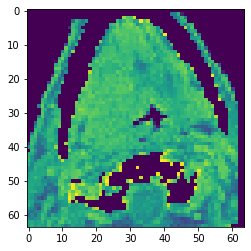

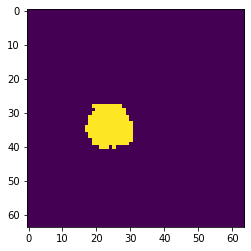

In [ ]:
test_,label = next(iter(train_data_loader))
print(test_.shape)
label.shape

plt.imshow(test_[0,0,...,0])
plt.pause(.2)
plt.imshow(label[0,0,...,0])

In [ ]:
out,u = extract_patches(X_torch, 2, 4,2) 
shape = out.shape
out = out.view(shape[0],shape[2]*shape[3]*shape[4], shape[1])
out = out.view(shape[0],shape[1], shape[2],shape[3],shape[4])
out = reshape_back(out,u)

print(out.shape)
out = np.array(out.detach())

plt.imshow(out[3,1,...])
print(np.max(out[3,1,...]))
plt.pause(.2)
plt.imshow(x[3,0,...,1])
print(np.max(x[3,0,...,1]))


RuntimeError: ignored

In [ ]:
# from torch import Tensor

# def dice_coeff(input: Tensor, target: Tensor,epsilon=1e-5):
#     dice = 0
#     target = torch.clamp(target, 0,1)
#     for i in range(input.shape[0]):
#         y_true = input[i,...]
#         y_pred = target[i,...]
#         zeros = torch.sum(y_true, dim = (0,2,3))
#         zeros = torch.nonzero(zeros) 
#         y_true = y_true[:,zeros[:,0],...]
#         y_pred = y_pred[:,zeros[:,0],...]
        
        
        
#         inter = torch.dot(y_true.reshape(-1), y_pred.reshape(-1))
#         sets_sum = torch.sum(y_true) + torch.sum(y_pred)
#         dice += (2 * inter + epsilon) / (sets_sum + epsilon)
        
#     return dice / input.shape[0]


# def dice_loss(input: Tensor, target: Tensor):
#     # Dice loss (objective to minimize) between 0 and 1
#     return 1 - dice_coeff(input, target)
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor,epsilon=1e-5):

    y_true = input
    y_pred = target

    y_pred = y_pred.permute(0,2,1,3,4)
    y_true = y_true.permute(0,2,1,3,4)

    shape = y_true.shape

    y_pred = y_pred.reshape(shape[0]*shape[1],shape[2],shape[3],shape[4])
    y_true = y_true.reshape(shape[0]*shape[1],shape[2],shape[3],shape[4])


    zeros = torch.sum(y_true,dim = (1,2,3))
    non_zeros = torch.nonzero(zeros) 
    y_pred = y_pred[non_zeros,].squeeze(1)
    y_true = y_true[non_zeros,].squeeze(1)

    batch = y_true.shape[0]

    inter = torch.sum(y_true.reshape(batch, -1)*y_pred.reshape(batch,-1),dim = 1)
    #A_sum = torch.sum(y_pred.reshape(-1)*y_pred.reshape(-1)) 
    #B_sum = torch.sum(y_true.reshape(-1)*y_true.reshape(-1))
    sets_sum = torch.sum(y_true.reshape(batch, -1),dim = 1) + torch.sum(y_pred.reshape(batch,-1),dim = 1)
    dice = (2 * inter + epsilon) / (sets_sum + epsilon)
    return torch.mean(dice)


def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - dice_coeff(input, target)

In [ ]:
import copy
y_pred = copy.deepcopy(y1)
y_pred = torch.Tensor(y_pred).permute(0,4,1,2,3)
shape = y_pred.shape
y_pred = y_pred.permute(0,2,1,3,4)
y_pred = y_pred.reshape(shape[0]*shape[2],shape[1],shape[3],shape[4])
print(y_pred.shape)
zeros = torch.sum(y_pred,dim = (1,2,3))
non_zeros = torch.nonzero(zeros) 
y_pred = y_pred[non_zeros,].squeeze(1)
print(y_pred.shape)

torch.Size([704, 1, 64, 64])
torch.Size([196, 1, 64, 64])


In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
import copy

In [ ]:
total_step = len(train_data_loader)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(2,1,32)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)
optimizer.zero_grad()

num_epochs = 1000
max_val_dce = 0
accum_iter = 1
early_stopping = 10
for epoch in range(num_epochs):
    epoch_avg_dice  = 0
    for i, (images, labels) in enumerate(train_data_loader):  
                
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute((0,4,1,2,3))
        labels = labels.permute((0,4,1,2,3))
        # Forward pass
        outputs = model(images)
        #outputs = outputs.permute(0,2,3,4,1)
        loss = dice_loss(labels, outputs).to(device)
        loss = loss/accum_iter

        epoch_avg_dice += dice_coeff(labels, outputs)
        # Backward and optimize
        #optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        #optimizer.step()

        # if ((i + 1) % accum_iter == 0) or (i + 1 == len(train_data_loader)):
        #     optimizer.step()
        #     optimizer.zero_grad()
        #print(str(dice_coeff(labels,outputs)))
        
    print("epoch " + str(epoch) + " done: dice = " + str(epoch_avg_dice/(i+1)))
    with torch.no_grad():
        val_dice_coef = 0
        total_val = len(test_data_loader)
        all_labels = []
        all_outputs = []
        for i, (images, labels) in enumerate(test_data_loader):  

            images = images.to(device)
            labels = labels.to(device)
            images = images.permute((0,4,1,2,3))
            labels = labels.permute((0,4,1,2,3))
            outputs = model(images)
            all_labels.append(labels)
            all_outputs.append(outputs)
            #outputs = outputs.permute(0,2,3,4,1)

        all_labels = torch.squeeze(torch.stack(all_labels, axis = 0),axis = 1)
        all_outputs = torch.squeeze(torch.stack(all_outputs,axis = 0),axis = 1)

        val_dice_coef += dice_coeff(all_labels, all_outputs)

        if val_dice_coef >= max_val_dce:
            torch.save(model.state_dict(), 'pytorch_stn_best.pt') 
            print("val dice coefficient increased from " + str(max_val_dce) + " to " + str(val_dice_coef) + ". Saving new model.")
            max_val_dce = val_dice_coef
            early_stopping = 10
        else:
            early_stopping = early_stopping - 1
        print("validation dice coefficent = " + str(val_dice_coef))     
        if early_stopping == 0:
            break
        

16
16
64
64
256
256
1024
1024
epoch 0 done: dice = tensor(0.3248, device='cuda:0', grad_fn=<DivBackward0>)
val dice coefficient increased from 0 to tensor(0.2973, device='cuda:0'). Saving new model.
validation dice coefficent = tensor(0.2973, device='cuda:0')
epoch 1 done: dice = tensor(0.4599, device='cuda:0', grad_fn=<DivBackward0>)
val dice coefficient increased from tensor(0.2973, device='cuda:0') to tensor(0.4766, device='cuda:0'). Saving new model.
validation dice coefficent = tensor(0.4766, device='cuda:0')
epoch 2 done: dice = tensor(0.5051, device='cuda:0', grad_fn=<DivBackward0>)
validation dice coefficent = tensor(0.4736, device='cuda:0')
epoch 3 done: dice = tensor(0.5219, device='cuda:0', grad_fn=<DivBackward0>)
val dice coefficient increased from tensor(0.4766, device='cuda:0') to tensor(0.4974, device='cuda:0'). Saving new model.
validation dice coefficent = tensor(0.4974, device='cuda:0')
epoch 4 done: dice = tensor(0.5475, device='cuda:0', grad_fn=<DivBackward0>)
valid

KeyboardInterrupt: ignored

In [ ]:
device = 'cuda'

model = UNet(2,1,32).to(device)
model.load_state_dict(torch.load("pytorch_stn_best.pt"))
validation_loaded = DataLoader(test, shuffle=False) # create your dataloader
all_outs = []
with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loaded):  
        images = images.permute((0,4,1,2,3))
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.permute((0,2,3,4,1))
        all_outs.append(outputs)

    all_outs = torch.stack(all_outs,dim = 0)
    print(all_outs.shape)
outputs = all_outs.cpu().detach()

16
16
64
64
256
256
1024
1024
torch.Size([22, 1, 32, 64, 64, 1])


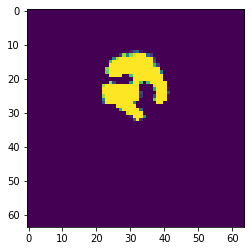

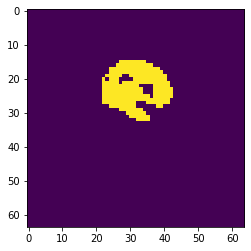

done


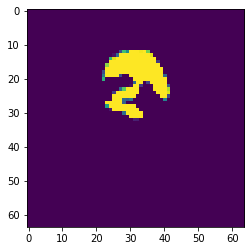

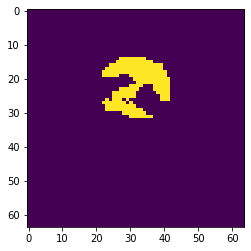

done


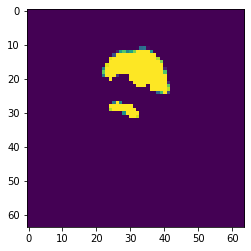

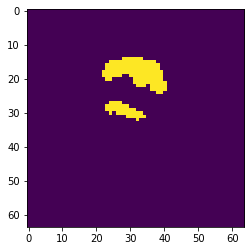

done


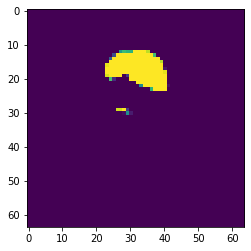

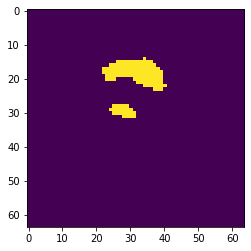

done


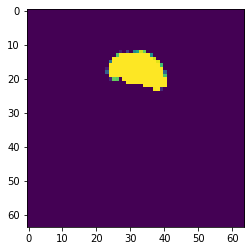

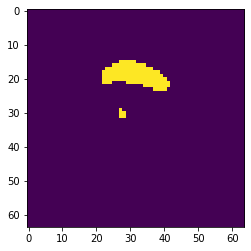

done


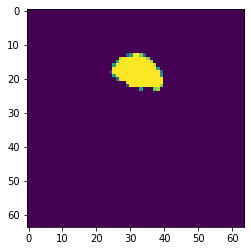

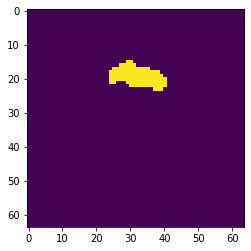

done


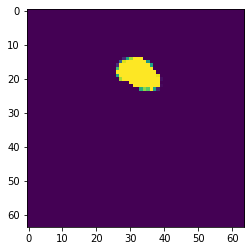

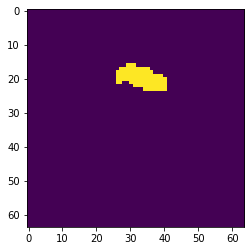

done


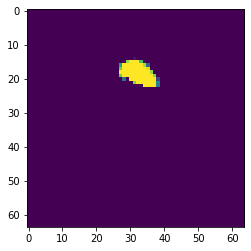

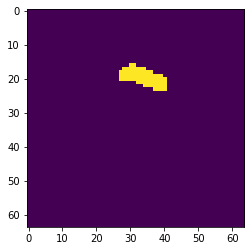

done


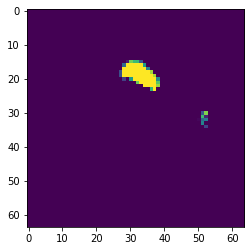

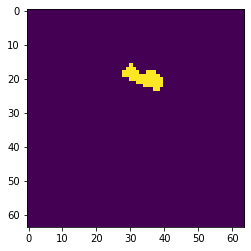

done


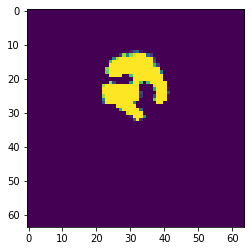

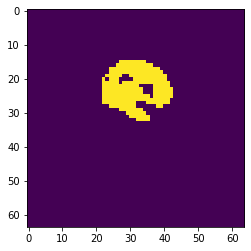

done


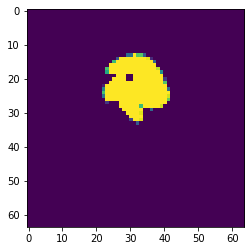

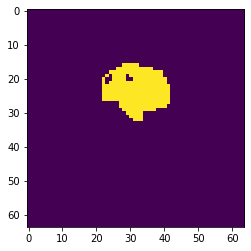

done


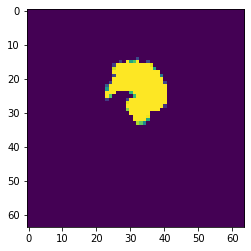

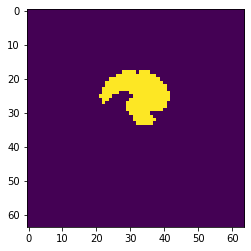

done


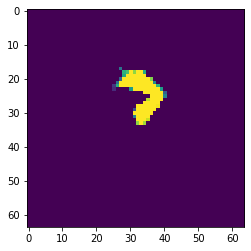

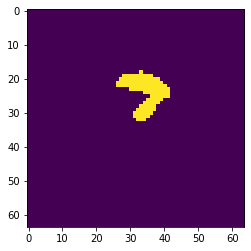

done


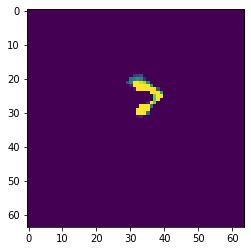

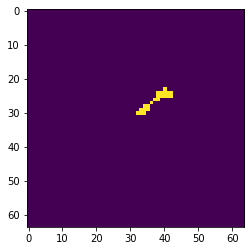

done


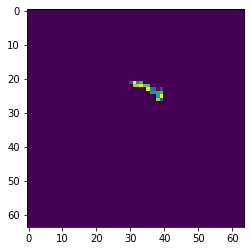

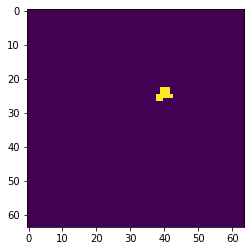

done


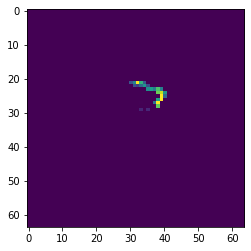

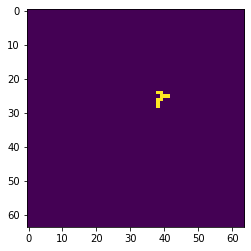

done


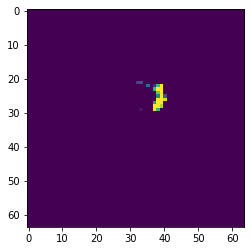

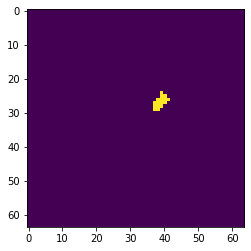

done


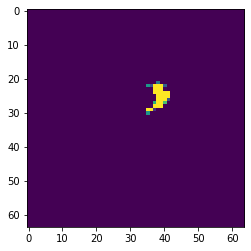

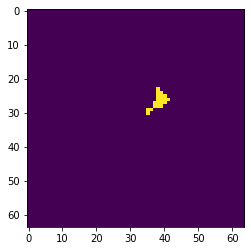

done


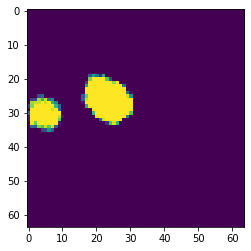

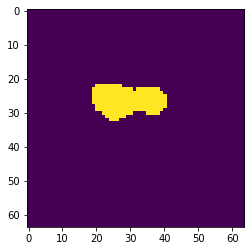

done


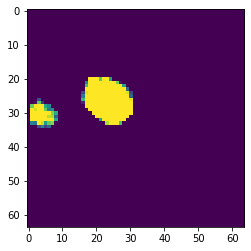

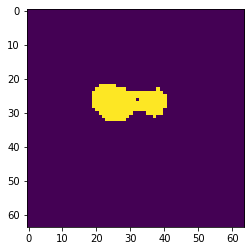

done


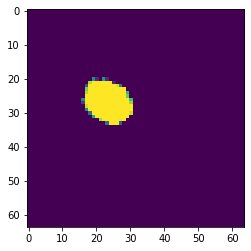

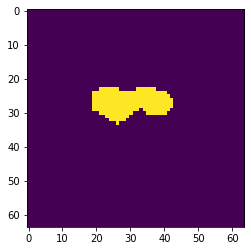

done


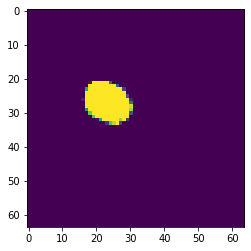

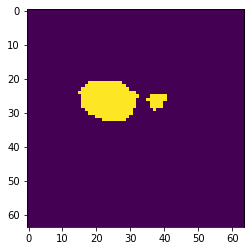

done


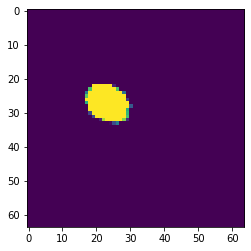

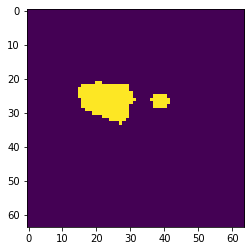

done


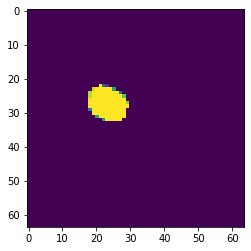

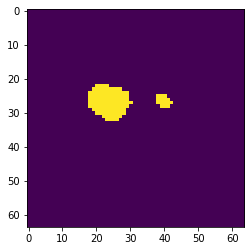

done


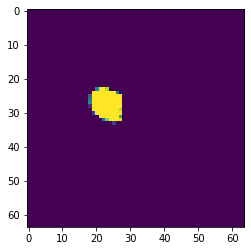

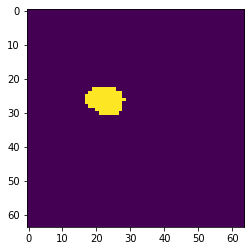

done


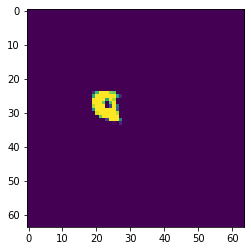

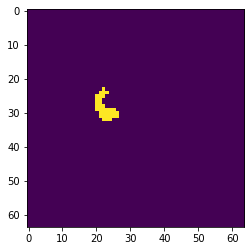

done


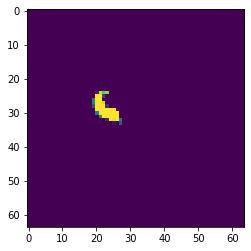

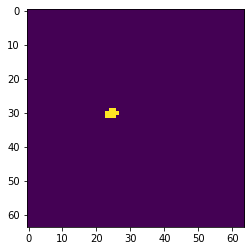

done


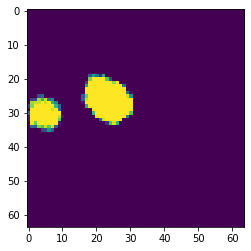

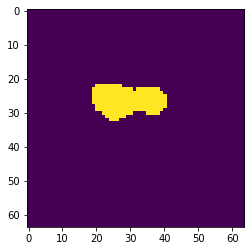

done


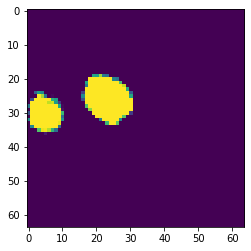

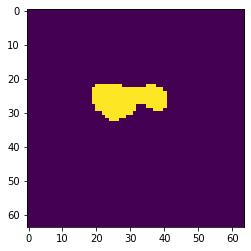

done


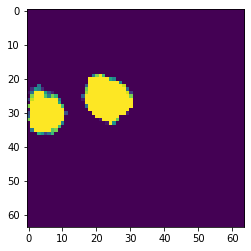

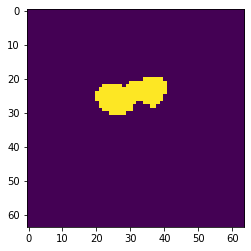

done


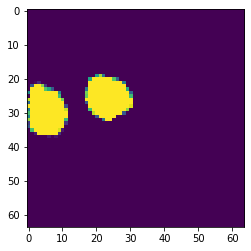

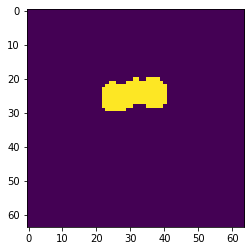

done


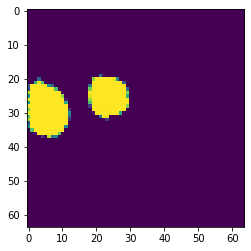

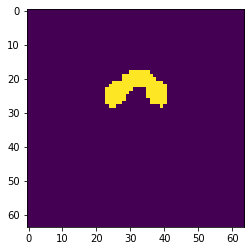

done


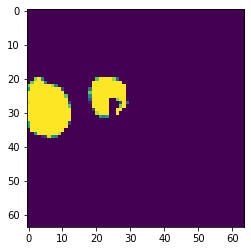

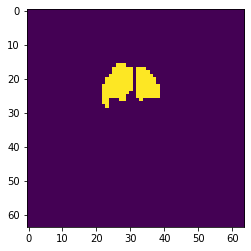

done


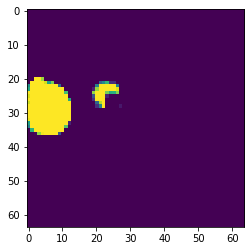

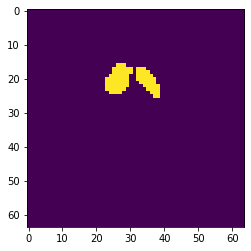

done


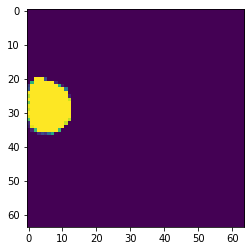

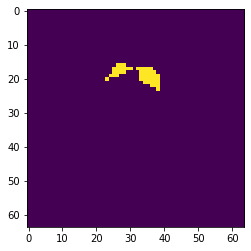

done


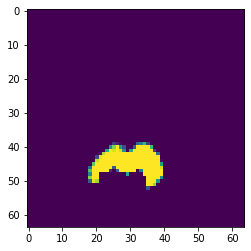

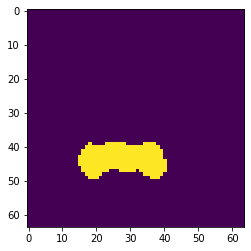

done


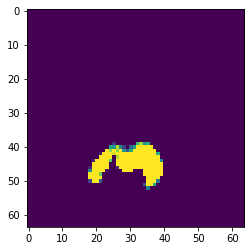

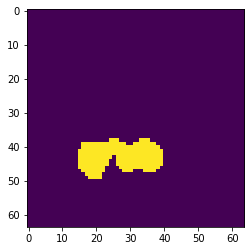

done


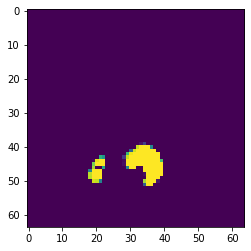

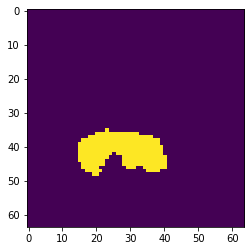

done


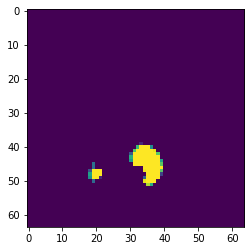

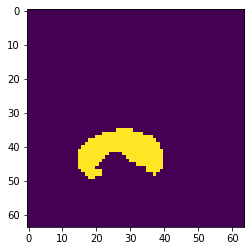

done


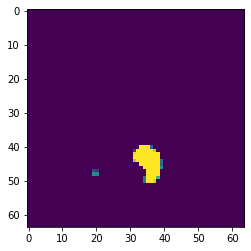

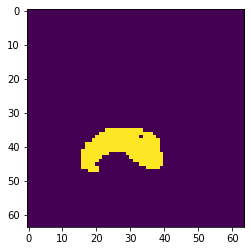

done


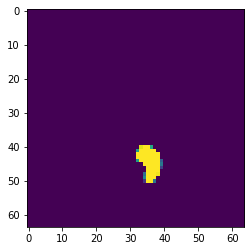

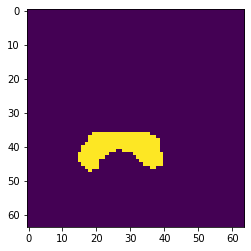

done


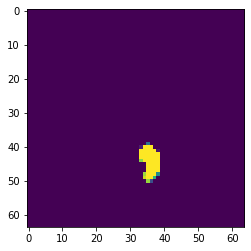

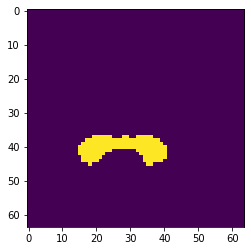

KeyboardInterrupt: ignored

In [ ]:
for i in range(outputs.shape[0]):
  for j in range(outputs.shape[2]):
    if np.sum(y1[i,j,...,0] > 0):
      plt.imshow(outputs[i,0,j,...,0])
      plt.pause(.2)
      plt.imshow(y1[i,j,...,0])
      plt.pause(.2)
      print("done")

In [ ]:
fit = np.array(outputs[:,0,...].detach())
print(fit.shape)

(22, 32, 64, 64, 1)


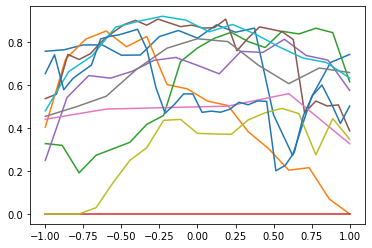

In [ ]:
def numpy_dice(y_true, y_pred, smooth  = 1):

    intersection = np.sum(y_true * y_pred, axis=(0,1))
    union = np.sum(y_true, axis=(0,1)) + np.sum(y_pred, axis=(0,1))
    return np.mean( (2. * intersection ) / (union ))
def normalize_var(array, x, y):
  m = np.min(array)
  range1 = np.max(array) - m
  array = (array - m) / range1
  #Then scale to [x,y]:
  range2 = y - x
  normalized = (array*range2) + x
  return normalized
tick = -1
change = 0
patientDCE = []
allPatientDCE = np.zeros((0,2))
every2 = 0
for i in range(0,len(y1)):
    k = 0
    for j in range(0,32):
        z = fit[i,j,...,0]
        z[np.where(z > 1)] = 1
        z[np.where(z < 0)] = 0

        truth = y1[i,j,...,0]

        if np.sum(truth) > 0:
            dce = numpy_dice(z, truth)

#             plt.imshow(truth)
#             plt.pause(.2)
#             plt.imshow(z)
#             plt.title(str(dce))
#             plt.pause(.2)
            patientDCE.append([tick*k,dce])
            k = k + 1
    every2 = every2 + 1
    tick = tick*-1
    if every2 == 2:
        patientDCE = np.array(patientDCE)
        patientDCE = patientDCE[patientDCE[:, 0].argsort()]
        patientDCE[:,0] = normalize_var(patientDCE[:,0], -1,1)
        plt.plot(patientDCE[:,0], patientDCE[:,1])
        allPatientDCE = np.concatenate((allPatientDCE, patientDCE),axis = 0)
        patientDCE = []
        every2 = 0
        
plt.show()

(0.0, 1.0)

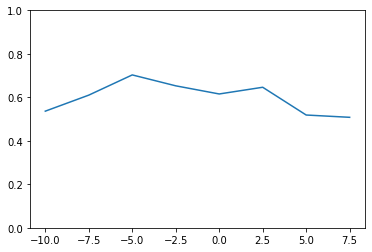

In [ ]:
import matplotlib.pyplot as plt
allPatientDCE[:,0] = allPatientDCE[:,0] *10
mean_loc = []
test_ = [-10,-7.5,-5,-2.5,0,2.5,5,7.5]

for i in test_:
    m = np.mean(allPatientDCE[np.where((allPatientDCE[:,0] > i) & (allPatientDCE[:,0] <= i + 2.5)),1])
    mean_loc.append([i,m])
    
mean_loc = np.array(mean_loc)

plt.plot(mean_loc[:,0],mean_loc[:,1])
plt.ylim(0,1)

In [ ]:
np.mean(allPatientDCE[:,1])

0.6072492267177222